In [ ]:
from google.colab import files

# Upload kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diwansachidu","key":"c5a90230a9bce82d66b0230464d1a4d3"}'}

In [ ]:
import os

# Create a directory for Kaggle configuration
!mkdir -p ~/.kaggle

# Move kaggle.json to the correct directory
!cp kaggle.json ~/.kaggle/

# Change permissions to avoid issues
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Install Kaggle API (if not installed already)
!pip install kaggle

# Download the dataset
!kaggle datasets download -d sumn2u/garbage-classification-v2

# Unzip the downloaded dataset
!unzip garbage-classification-v2.zip -d garbage_classification

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/garbage-dataset/paper/paper_3158.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3159.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_316.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3160.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3161.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3162.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3165.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3168.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3169.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3170.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3171.jpg  
  inflating: garbage_classification/garbage-dataset/paper/paper_3172.jpg  
  inflating: garbage_classification/garbage-datase

In [ ]:
import os

# Path to the dataset
base_dir = '/content/dataset'

# List class folders, excluding hidden/system folders
classes = [cls for cls in os.listdir(base_dir) if not cls.startswith('.')]
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")

# Check the number of files in each class
for category in classes:
    category_path = os.path.join(base_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} images")


Classes: ['paper', 'plastic', 'biological', 'glass']
Number of classes: 4
paper: 1650 images
plastic: 1915 images
biological: 983 images
glass: 3039 images


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)  # Resize images to 224x224
BATCH_SIZE = 32  # Batch size for loading

# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize to 224x224
    image = image / 255.0  # Normalize pixel values (0-1)
    return image, label


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load data dynamically and split
dataset = image_dataset_from_directory(
    'dataset',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

# Split dataset into train, validation, and test
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_dataset = dataset.take(int(len(dataset) * train_size))
val_dataset = dataset.skip(int(len(dataset) * train_size)).take(int(len(dataset) * val_size))
test_dataset = dataset.skip(int(len(dataset) * (train_size + val_size)))

print(f"Train: {len(train_dataset)} batches, Validation: {len(val_dataset)} batches, Test: {len(test_dataset)} batches")


Found 7587 files belonging to 4 classes.
Train: 166 batches, Validation: 35 batches, Test: 36 batches


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
%pip install Pillow
%pip install scikit-learn
%pip install matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
from sklearn.utils import class_weight

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Dataset
dataset = image_dataset_from_directory(
    'dataset',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

# Split Dataset
train_size = 0.7
val_size = 0.15

train_dataset = dataset.take(int(len(dataset) * train_size))
val_dataset = dataset.skip(int(len(dataset) * train_size)).take(int(len(dataset) * val_size))
test_dataset = dataset.skip(int(len(dataset) * (train_size + val_size)))

# Prefetch Datasets for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Calculate Class Weights
class_counts = [983,3039,1650,1915]
class_labels = list(range(4))
weights = class_weight.compute_class_weight(
    'balanced', classes=np.array(class_labels), y=np.repeat(class_labels, class_counts)
)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)


Found 7587 files belonging to 4 classes.
Class Weights: {0: 1.9295523906408951, 1: 0.6241362290227048, 2: 1.1495454545454546, 3: 0.9904699738903394}


In [ ]:
for i, count in enumerate(class_counts):
    print(f"Class {i}: Count = {count}, Weight = {class_weights[i]:.2f}")


Class 0: Count = 983, Weight = 1.93
Class 1: Count = 3039, Weight = 0.62
Class 2: Count = 1650, Weight = 1.15
Class 3: Count = 1915, Weight = 0.99


In [ ]:
import os
from PIL import Image

def validate_and_clean_dataset(source_dir, dest_dir):
    """
    Copies and validates images from source_dir to dest_dir.
    Converts RGBA and CMYK images to RGB and saves them as PNG to handle unsupported modes.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_dir in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        if not os.path.exists(dest_class_path):
            os.makedirs(dest_class_path)

        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            try:
                # Validate image by opening it
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image integrity

                # Open the image again to process and save
                with Image.open(file_path) as img:
                    # Convert RGBA or CMYK to RGB if necessary
                    if img.mode in ('RGBA', 'CMYK'):
                        img = img.convert('RGB')

                    # Save as PNG to handle all formats
                    dest_file_path = os.path.join(dest_class_path, filename)
                    img.save(dest_file_path, format='JPG')  # Save as PNG
            except Exception as e:
                print(f"Skipping file {file_path}: {e}")

# Source and destination directories
source_dir = 'dataset'
dest_dir = 'cleaned-dataset'

# Validate and clean the dataset
validate_and_clean_dataset(source_dir, dest_dir)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

cleaned_dir = 'cleaned-dataset'

# Reload dataset
dataset = image_dataset_from_directory(
    cleaned_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

# Split Dataset
train_size = 0.7
val_size = 0.15

train_dataset = dataset.take(int(len(dataset) * train_size))
val_dataset = dataset.skip(int(len(dataset) * train_size)).take(int(len(dataset) * val_size))
test_dataset = dataset.skip(int(len(dataset) * (train_size + val_size)))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Found 7587 files belonging to 4 classes.


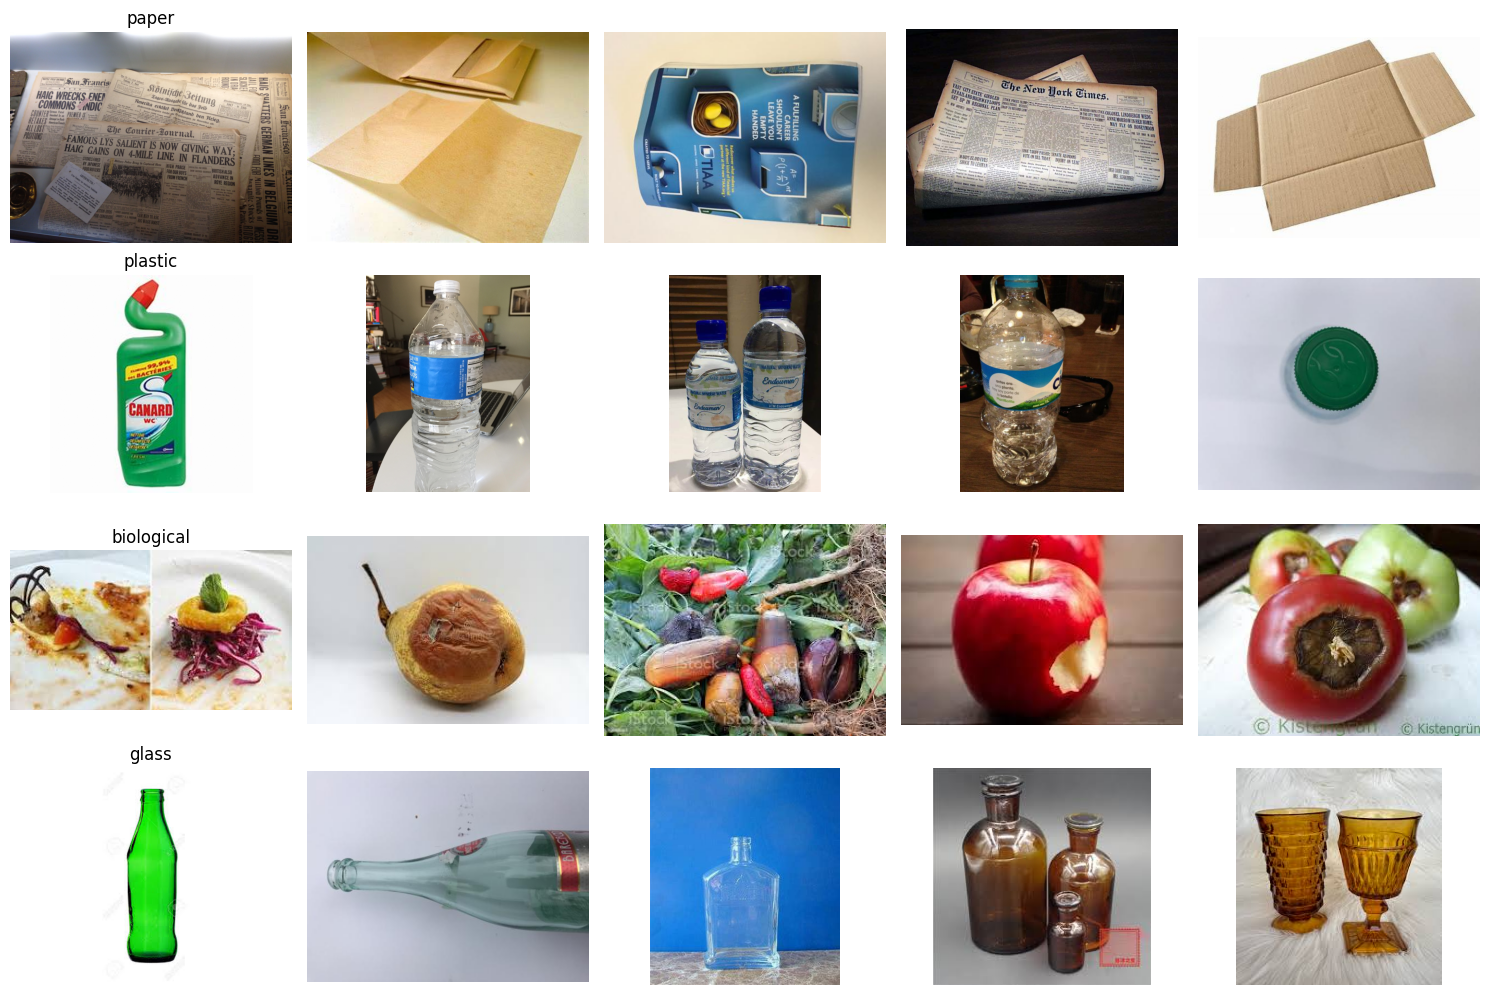

In [ ]:
import matplotlib.pyplot as plt
import random

def display_sample_images(directory, num_samples=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, 10))

    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)
        sample_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(cls)

    plt.tight_layout()
    plt.show()

# Display samples from cleaned dataset
display_sample_images(cleaned_dir)

# MobileNetV2 model

In [ ]:
# Load a pretrained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add a custom classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')  # Adjust output to match the number of classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 144s 776ms/step - accuracy: 0.4614 - loss: 1.1778 - val_accuracy: 0.6491 - val_loss: 0.8321
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6600 - loss: 0.7478 - val_accuracy: 0.6884 - val_loss: 0.7503
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7050 - loss: 0.6786 - val_accuracy: 0.7009 - val_loss: 0.7269
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7147 - loss: 0.6290 - val_accuracy: 0.7054 - val_loss: 0.7027
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7360 - loss: 0.5881 - val_accuracy: 0.7152 - val_loss: 0.6743
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7429 - loss: 0.5836 - val_accuracy: 0.7268 - val_loss: 0.6636
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7394 - loss: 0.5666 - val_accuracy: 0.7152 - val_loss: 0.6730
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 10

In [ ]:
# Save the trained MobileNetV2 model
model.save('mobilenetv2_garbage_classifier.h5')
print("MobileNetV2 model saved successfully.")

MobileNetV2 model saved successfully.


# ResNet50 model

In [ ]:
import tensorflow as tf

# Load a pretrained ResNet50 model
base_model_resnet = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_resnet.trainable = False  # Freeze the base model

# Add a custom classification head
model_resnet = tf.keras.Sequential([
    base_model_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')  # 10 classes
])

# Compile the model
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_resnet = model_resnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model on the test dataset
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_dataset)
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet * 100:.2f}%")

# Save the ResNet50 model
model_resnet.save('resnet50_garbage_classifier.h5')
print("ResNet50 model saved successfully.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.7194 - loss: 0.6459 - val_accuracy: 0.9286 - val_loss: 0.2205
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - accuracy: 0.9173 - loss: 0.1825 - val_accuracy: 0.9393 - val_loss: 0.1867
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9293 - loss: 0.1521 - val_accuracy: 0.9429 - val_loss: 0.1744
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9432 - loss: 0.1260 - val_accuracy: 0.9482 - val_loss: 0.1678
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.9501 - loss: 0.1073 - val_accuracy: 0.9500 - val_loss: 0.1610
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9545 - loss: 0.0999 - val_accuracy: 0.9491 - val_loss: 0.1642
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9586 - loss: 0.0898 - val_accuracy: 0.9518 - val_loss: 0.1524
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━

ResNet50 Test Accuracy: 95.10%
ResNet50 model saved successfully.


# VGG19 model

In [ ]:
import tensorflow as tf

# Load a pretrained VGG19 model
base_model_vgg19 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_vgg19.trainable = False  # Freeze the base model

# Add a custom classification head
model_vgg19 = tf.keras.Sequential([
    base_model_vgg19,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')  # 10 classes
])

# Compile the model
model_vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_vgg19 = model_vgg19.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model on the test dataset
test_loss_vgg19, test_accuracy_vgg19 = model_vgg19.evaluate(test_dataset)
print(f"VGG19 Test Accuracy: {test_accuracy_vgg19 * 100:.2f}%")

# Save the VGG19 model
model_vgg19.save('vgg19_garbage_classifier.h5')
print("VGG19 model saved successfully.")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.5416 - loss: 3.0148 - val_accuracy: 0.8714 - val_loss: 0.5276
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.8379 - loss: 0.6603 - val_accuracy: 0.9018 - val_loss: 0.3532
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.8659 - loss: 0.4759 - val_accuracy: 0.9116 - val_loss: 0.2925
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.8914 - loss: 0.3839 - val_accuracy: 0.9241 - val_loss: 0.2456
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 47s 211ms/step - accuracy: 0.9065 - loss: 0.3033 - val_accuracy: 0.9232 - val_loss: 0.2414
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - accuracy: 0.9061 - loss: 0.2737 - val_accuracy: 0.9214 - val_loss: 0.2235
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.9027 - loss: 0.2591 - val_accuracy: 0.9286 - val_loss: 0.2025
Epoch 8/10
166/166 ━━━━━━━━━━━━━

VGG19 Test Accuracy: 92.34%
VGG19 model saved successfully.


# Xception model

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

# Load pre-trained Xception model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model_xception.trainable = False

# Add a custom classification head
model_xception = models.Sequential([
    base_model_xception,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(classes), activation='softmax')  # 10 classes
])

# Compile the model
model_xception.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_xception = model_xception.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model
test_loss_xception, test_accuracy_xception = model_xception.evaluate(test_dataset)
print(f"Xception Test Accuracy: {test_accuracy_xception * 100:.2f}%")

# Save the model
model_xception.save('xception_garbage_classifier.h5')
print("Xception model saved successfully.")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.3518 - loss: 11.5730 - val_accuracy: 0.4830 - val_loss: 6.3033
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.4682 - loss: 5.4534 - val_accuracy: 0.5768 - val_loss: 2.5933
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.5223 - loss: 3.4053 - val_accuracy: 0.6071 - val_loss: 2.1006
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.5297 - loss: 2.7255 - val_accuracy: 0.6313 - val_loss: 1.5651
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.5516 - loss: 2.5664 - val_accuracy: 0.6241 - val_loss: 1.5321
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.5659 - loss: 2.1378 - val_accuracy: 0.5938 - val_loss: 1.7056
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.5630 - loss: 2.0977 - val_accuracy: 0.6036 - val_loss: 1.4540
Epoch 8/10
166/166 ━━━━━━━━━━━━

Xception Test Accuracy: 60.91%
Xception model saved successfully.


# DenseNet201 model

In [ ]:
import tensorflow as tf

# Load a pretrained DenseNet201 model
base_model_densenet = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model_densenet.trainable = False  # Freeze the base model

# Add a custom classification head
model_densenet = tf.keras.Sequential([
    base_model_densenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')  # 04 classes - number of classes
])

# Compile the model
model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_densenet = model_densenet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model on the test dataset
test_loss_densenet, test_accuracy_densenet = model_densenet.evaluate(test_dataset)
print(f"DenseNet201 Test Accuracy: {test_accuracy_densenet * 100:.2f}%")

# Save the DenseNet model
model_densenet.save('densenet201_garbage_classifier.h5')
print("DenseNet201 model saved successfully.")

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.3921 - loss: 3.0490 - val_accuracy: 0.6679 - val_loss: 0.9770
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 83s 147ms/step - accuracy: 0.6237 - loss: 1.1021 - val_accuracy: 0.7411 - val_loss: 0.7210
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.6870 - loss: 0.8136 - val_accuracy: 0.7625 - val_loss: 0.6224
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.7215 - loss: 0.7305 - val_accuracy: 0.7741 - val_loss: 0.6138
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7422 - loss: 0.6209 - val_accuracy: 0.7527 - val_loss: 0.6550
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.7457 - loss: 0.6153 - val_accuracy: 0.7759 - val_loss: 0.6079
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.7514 - loss: 0.6277 - val_accuracy: 0.7732 - val_loss: 0.5864
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.7487 - loss: 0.5

DenseNet201 Test Accuracy: 79.79%
DenseNet201 model saved successfully.


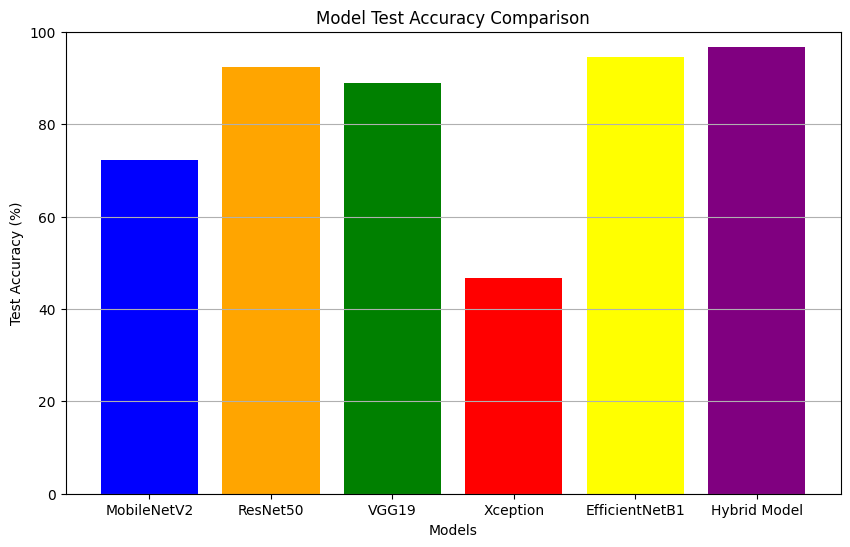

In [ ]:
import matplotlib.pyplot as plt

models = ['MobileNetV2', 'ResNet50', 'VGG19', 'Xception', 'EfficientNetB1', 'Hybrid Model']
accuracies = [72.33, 92.38, 89.00, 46.67, 94.55, 96.67]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'yellow', 'purple'])
plt.title('Model Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

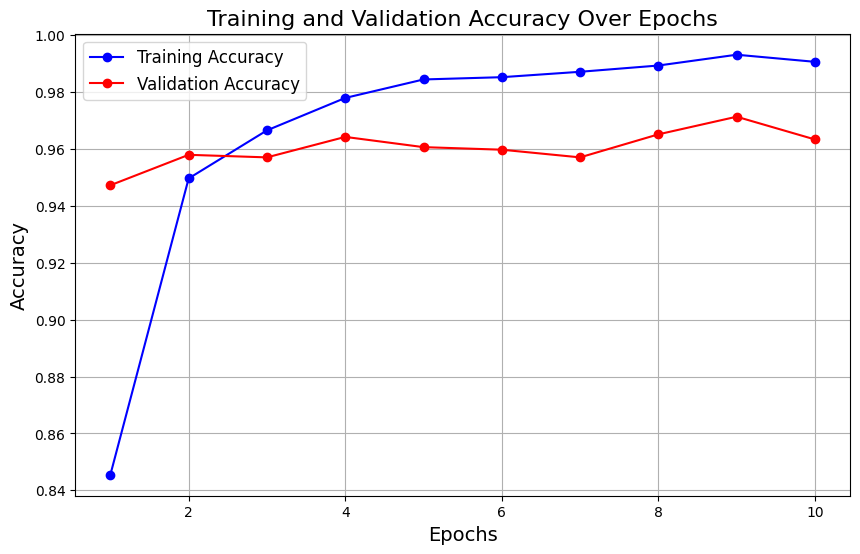

In [ ]:
import matplotlib.pyplot as plt

train_acc = [0.8455, 0.9497, 0.9666, 0.9780, 0.9845, 0.9853, 0.9872, 0.9894, 0.9932, 0.9907]  # Training accuracy per epoch
val_acc = [0.9473, 0.9580, 0.9571, 0.9643, 0.9607, 0.9598, 0.9571, 0.9652, 0.9714, 0.9634]    # Validation accuracy per epoch
epochs = range(1, len(train_acc) + 1)  # Number of epochs

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')

# Adding labels, title, and legend
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.show()



# EfficientNetB1 model

In [ ]:
import tensorflow as tf

# Load the pre-trained EfficientNetB1 model (without top layer)
base_model_effb1 = tf.keras.applications.EfficientNetB1(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model_effb1.trainable = False

# Add a custom classification head on top
model_effb1 = tf.keras.Sequential([
    base_model_effb1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')  # 10 classes for garbage classification
])

# Compile the model
model_effb1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_effb1 = model_effb1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the model on the test dataset
test_loss_effb1, test_accuracy_effb1 = model_effb1.evaluate(test_dataset)
print(f"EfficientNetB1 Test Accuracy: {test_accuracy_effb1 * 100:.2f}%")

# Save the EfficientNetB1 model
model_effb1.save('efficientnetb1_garbage_classifier.h5')
print("EfficientNetB1 model saved successfully.")

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 186s 877ms/step - accuracy: 0.7501 - loss: 0.6488 - val_accuracy: 0.9286 - val_loss: 0.2256
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9313 - loss: 0.1765 - val_accuracy: 0.9393 - val_loss: 0.1822
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9412 - loss: 0.1399 - val_accuracy: 0.9438 - val_loss: 0.1583
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9463 - loss: 0.1236 - val_accuracy: 0.9464 - val_loss: 0.1495
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9553 - loss: 0.1078 - val_accuracy: 0.9500 - val_loss: 0.1392
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9577 - loss: 0.0989 - val_accuracy: 0.9563 - val_loss: 0.1361
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9552 - loss: 0.0952 - val_accuracy: 0.9527 - val_loss: 0.1311
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9593 - loss: 0.0888 - 

EfficientNetB1 Test Accuracy: 95.55%
EfficientNetB1 model saved successfully.


# Hybrid ResNet50 + EfficientNetB1

In [ ]:
import tensorflow as tf

# Load ResNet50 without top layers
resnet50_base = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
resnet50_base.trainable = False  # Freeze ResNet50 layers

# Load EfficientNetB1 without top layers
effb1_base = tf.keras.applications.EfficientNetB1(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
effb1_base.trainable = False  # Freeze EfficientNetB1 layers

# Define inputs
input_layer = tf.keras.Input(shape=(224, 224, 3))

# Extract features using both models
resnet50_features = resnet50_base(input_layer)
resnet50_features = tf.keras.layers.GlobalAveragePooling2D()(resnet50_features)

effb1_features = effb1_base(input_layer)
effb1_features = tf.keras.layers.GlobalAveragePooling2D()(effb1_features)

# Combine features from both models
combined_features = tf.keras.layers.Concatenate()([resnet50_features, effb1_features])

# Add a custom classification head
x = tf.keras.layers.Dense(512, activation='relu')(combined_features)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(x)  # Adjust classes

# Create the hybrid model
hybrid_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the hybrid model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the hybrid model
history_hybrid = hybrid_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# Evaluate the hybrid model on the test set
test_loss_hybrid, test_accuracy_hybrid = hybrid_model.evaluate(test_dataset)
print(f"Hybrid Model Test Accuracy: {test_accuracy_hybrid * 100:.2f}%")

# Save the hybrid model
hybrid_model.save('hybrid_resnet50_effb1_classifier.h5')
print("Hybrid ResNet50 + EfficientNetB1 model saved successfully.")

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 93s 241ms/step - accuracy: 0.8455 - loss: 0.4295 - val_accuracy: 0.9473 - val_loss: 0.1377
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - accuracy: 0.9497 - loss: 0.1039 - val_accuracy: 0.9580 - val_loss: 0.1258
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.9666 - loss: 0.0695 - val_accuracy: 0.9571 - val_loss: 0.1244
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9780 - loss: 0.0545 - val_accuracy: 0.9643 - val_loss: 0.1269
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.9845 - loss: 0.0335 - val_accuracy: 0.9607 - val_loss: 0.1320
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9853 - loss: 0.0248 - val_accuracy: 0.9598 - val_loss: 0.1318
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9872 - loss: 0.0257 - val_accuracy: 0.9571 - val_loss: 0.1467
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9894 - loss: 0

Hybrid Model Test Accuracy: 95.28%
Hybrid ResNet50 + EfficientNetB1 model saved successfully.


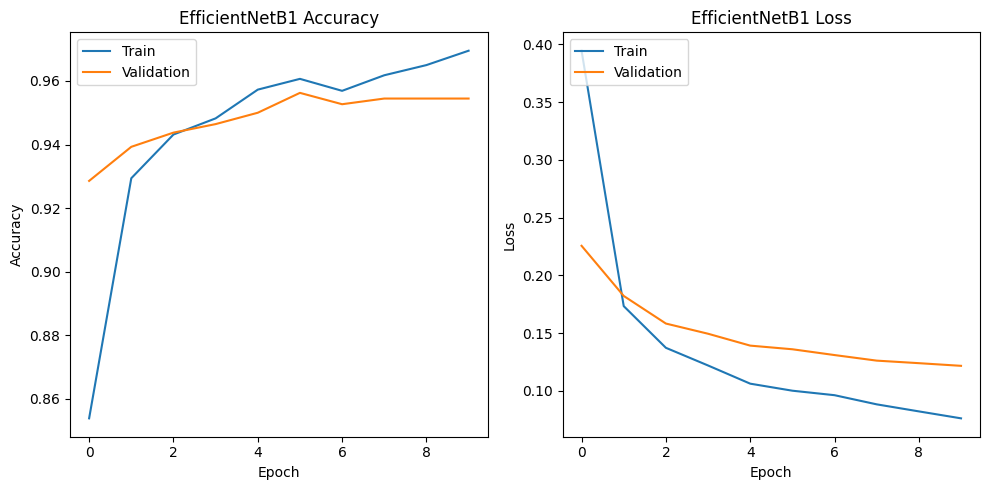

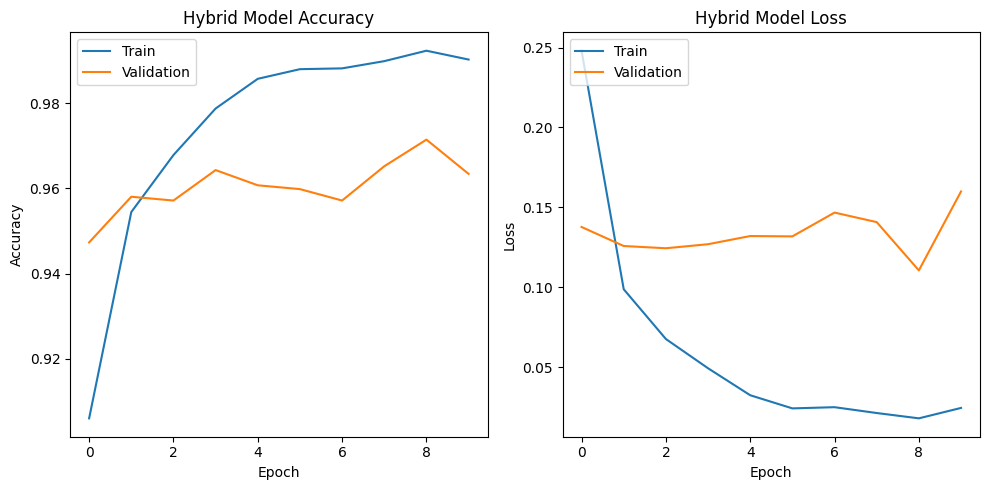

In [ ]:
# prompt: can we plot different graphs of different model the accuracy and the loss

import matplotlib.pyplot as plt

def plot_model_history(history, model_name):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# plot_model_history(history, 'MobileNetV2')
# plot_model_history(history_resnet, 'ResNet50')
# plot_model_history(history_vgg19, 'VGG19')
# plot_model_history(history_xception, 'Xception')
# plot_model_history(history_densenet, 'DenseNet201')
plot_model_history(history_effb1, 'EfficientNetB1')
plot_model_history(history_hybrid, 'Hybrid Model')